# Simulation of BBOB F03

Approach:
- SVM with RBF-Kernel
- 1000 random samples

In [1]:
import sys
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr

sys.path.append('..')
from utils.utils import create_problem, plot_collage, test_function, calculate_eval_metrics
from utils.optimizer import perform_optimization, plot_optimization, plot_optimization_paths
from gt_sampling import get_sample

## Create Groundtruth

In [2]:
n_dim = 2
samples = 1000
seed = 42

problem_f03 = create_problem(3, n_dim, seed)

## Sample from Groundtruth

In [3]:
sample_f03 = get_sample(problem_f03, n_samples=samples, n_dim=2, seed=42, method='random')

c:\Users\schla\git\OptimizationTestfunctionGeneration\main\gt_sampling.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_sample = torch.tensor(result[i], dtype=torch.float64).reshape((1, n_dim)).float()


In [4]:
X_input = torch.tensor(sample_f03[0], dtype=torch.float32).clone().detach()
y_input = sample_f03[1].float()  

# input with gradients
X_input_grad1 = torch.tensor(np.concatenate((X_input, sample_f03[2]), axis=1), dtype=torch.float32).clone().detach()

C:\Users\schla\AppData\Local\Temp\ipykernel_31960\2673204988.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_input = torch.tensor(sample_f03[0], dtype=torch.float32).clone().detach()


## Train SVM for Simulation

### Classic SVM

In [5]:
svm_p3 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf', C=10, gamma=0.6)),
])

In [6]:
svm_p3.fit(X_input, y_input)

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVR(C=10, gamma=0.6))])

Export model:

In [7]:
FOLDER = '../models'
pickle.dump(svm_p3, open(f'{FOLDER}/SVM-P03-Classic.pkl', 'wb'))

### SVM with gradients 

In [8]:
svm_grad = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf', C=10, gamma=0.6)),
])

In [9]:
# train model with gradients
svm_grad.fit(X_input_grad1, y_input)

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVR(C=10, gamma=0.6))])

In [10]:
pickle.dump(svm_grad, open(f'{FOLDER}/SVM-P03-Grads.pkl', 'wb'))

(estimated by nearest neighbor)

In [11]:
# wrap svm and estimate gradients with nearest neighbor
def svm_grad_1nn(X):
    return test_function(X, X_input, X_input_grad1[:, 2:4], svm_grad, method='nearest_neighbor')

(estimated by GPM)

In [12]:
gradient_estimator = MultiOutputRegressor(GaussianProcessRegressor())
gradient_estimator.fit(X_input, X_input_grad1[:, 2:4])

def svm_grad_gpm(X):
    return test_function(X, X_input, X_input_grad1[:, 2:4], svm_grad, method='estimator', gradient_estimator=gradient_estimator)

## Evaluation

### Graphical Evaluation

In [13]:
x1 = x2 = np.linspace(-5.0, 5.0, 100)
X1, X2 = np.meshgrid(x1, x2)

mesh_samples = np.c_[X1.ravel(), X2.ravel()]
mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)


In [14]:
mesh_results_svm_p3 = svm_p3.predict(mesh_samples_tensor).reshape(X1.shape)

c:\ProgramData\Anaconda3\envs\python-3-10-env\MachineLearningProject\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<Axes: title={'center': 'Ground Truth of BBOB F03 Function'}, xlabel='X', ylabel='Y'>

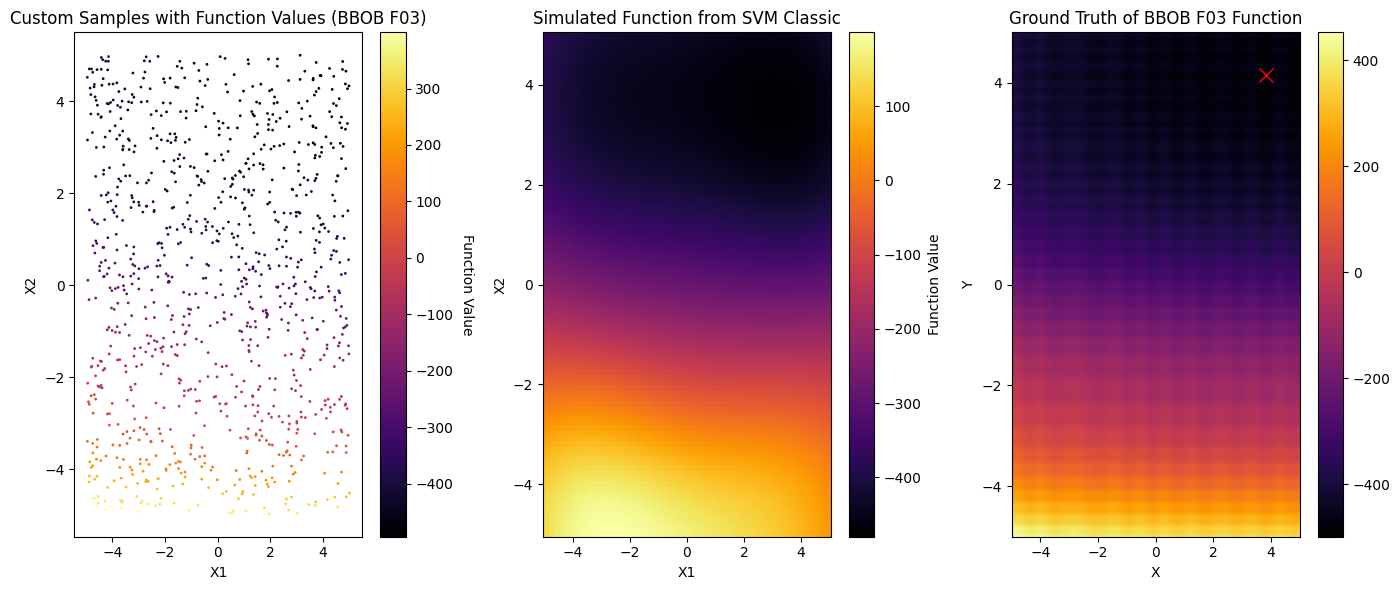

In [15]:
plot_collage(sample_f03[0], sample_f03[1], problem_f03, "BBOB F03", "SVM Classic", X1, X2, mesh_results_svm_p3)

--> on first glance: Classic SVM with RBF-Kernel can capture the third BBOB function's global structure quite well. However, the local structure is not represented at all, the model interpolates all local optima

In [16]:
mesh_results_svm_grad_1nn = svm_grad_1nn(mesh_samples_tensor).reshape(X1.shape)

<Axes: title={'center': 'Ground Truth of BBOB F03 Function'}, xlabel='X', ylabel='Y'>

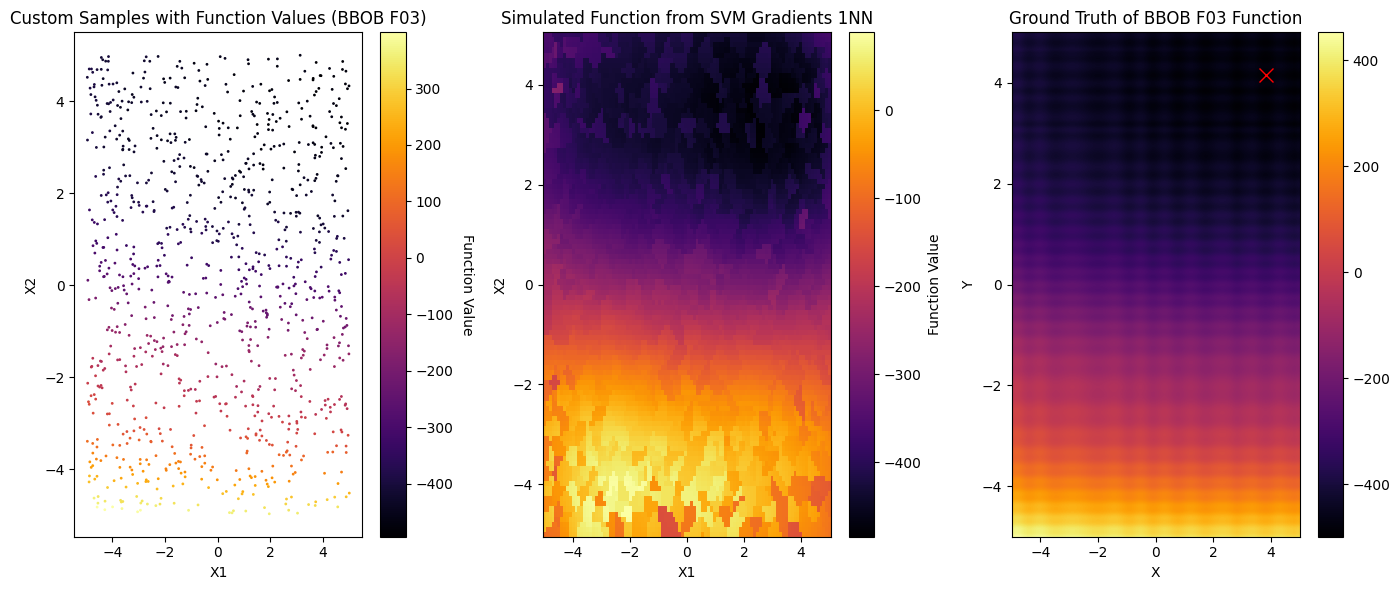

In [17]:
plot_collage(sample_f03[0], sample_f03[1], problem_f03, "BBOB F03", "SVM Gradients 1NN", X1, X2, mesh_results_svm_grad_1nn)

In [18]:
mesh_results_svm_grad_gpm = svm_grad_gpm(mesh_samples_tensor).reshape(X1.shape)

<Axes: title={'center': 'Ground Truth of BBOB F03 Function'}, xlabel='X', ylabel='Y'>

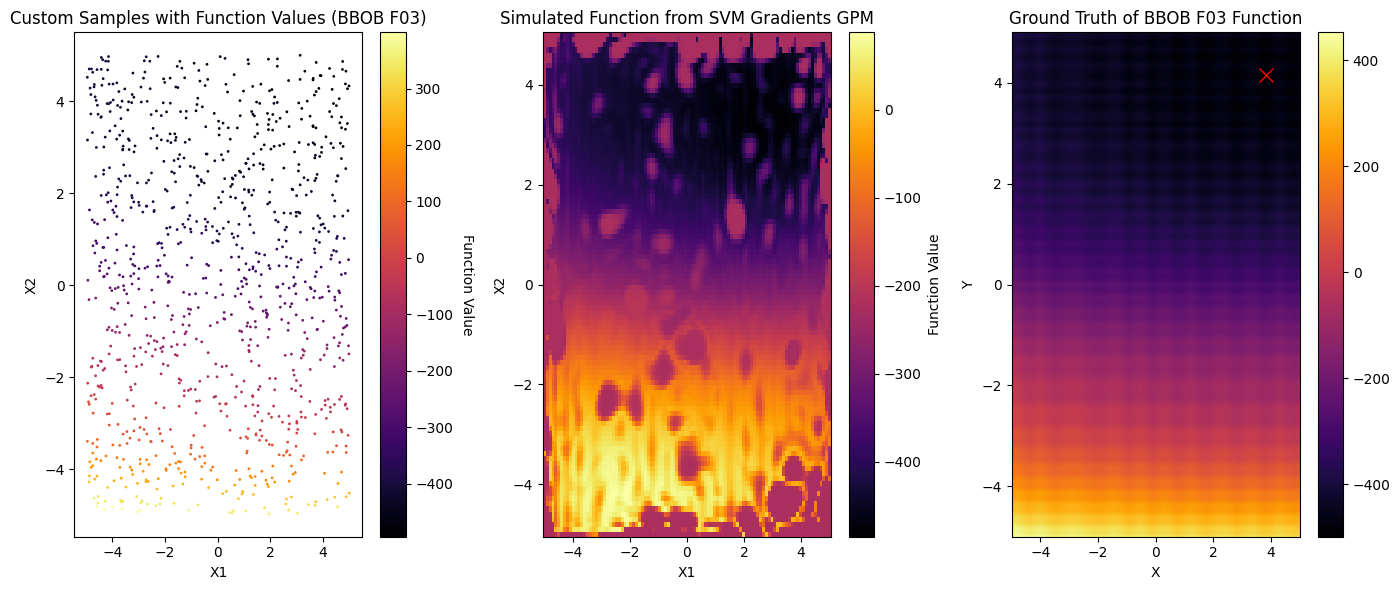

In [19]:
plot_collage(sample_f03[0], sample_f03[1], problem_f03, "BBOB F03", "SVM Gradients GPM", X1, X2, mesh_results_svm_grad_gpm)

### Evaluation with metrics

tbd

### Evaluation with optimizer

In [20]:
svm_classic_f = lambda x: svm_p3.predict(x.reshape(1, -1) if len(x.shape) == 1 else x)
svm_grads_1nn_f = lambda x: svm_grad_1nn(x.reshape(1, -1) if len(x.shape) == 1 else x)
svm_grads_gpm_f= lambda x: svm_grad_gpm(x.reshape(1, -1) if len(x.shape) == 1 else x)
problem_f03_ = lambda x: problem_f03(x.reshape(1, -1) if len(x.shape) == 1 else x)

functions = [
               [problem_f03_, 'Groundtruth']
             , [svm_classic_f, 'SVM-Classic']
             , [svm_grads_1nn_f, 'SVM-Gradients-1NN']
             , [svm_grads_gpm_f, 'SVM-Gradients-GPM']
]

In [21]:
opt = problem_f03(problem_f03.x_opt.reshape(1,-1))[0]

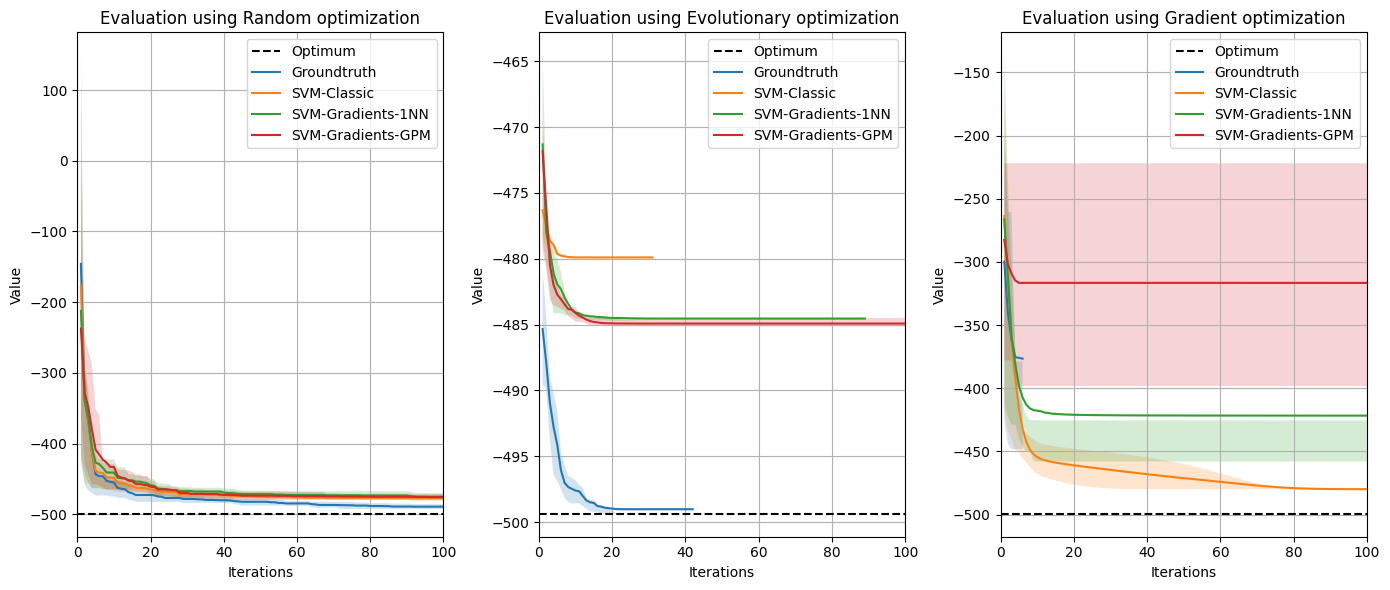

In [23]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.hlines(opt, 0, 100, colors='k', linestyles='dashed', label='Optimum')
plot_optimization(functions, 'Random', n_dim=2, n_times=20, i_evaluations=100, seed=42)
plt.subplot(1, 3, 2)
plt.hlines(opt, 0, 100, colors='k', linestyles='dashed', label='Optimum')
plot_optimization(functions, 'Evolutionary', n_dim=2, n_times=20, i_evaluations=100, seed=42)
plt.subplot(1, 3, 3)
plt.hlines(opt, 0, 100, colors='k', linestyles='dashed', label='Optimum')
plot_optimization(functions, 'Gradient', n_dim=2, n_times=20, i_evaluations=100, seed=42)
plt.xlim(0,100)
plt.tight_layout()
plt.show()

C:\Users\schla\AppData\Local\Temp\ipykernel_31960\1617589034.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_optimization_paths(functions, 'Random', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'], seed=100).show()
C:\Users\schla\AppData\Local\Temp\ipykernel_31960\1617589034.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_optimization_paths(functions, 'Evolutionary', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'], seed=100).show()
C:\Users\schla\AppData\Local\Temp\ipykernel_31960\1617589034.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_optimization_paths(functions, 'Gradie

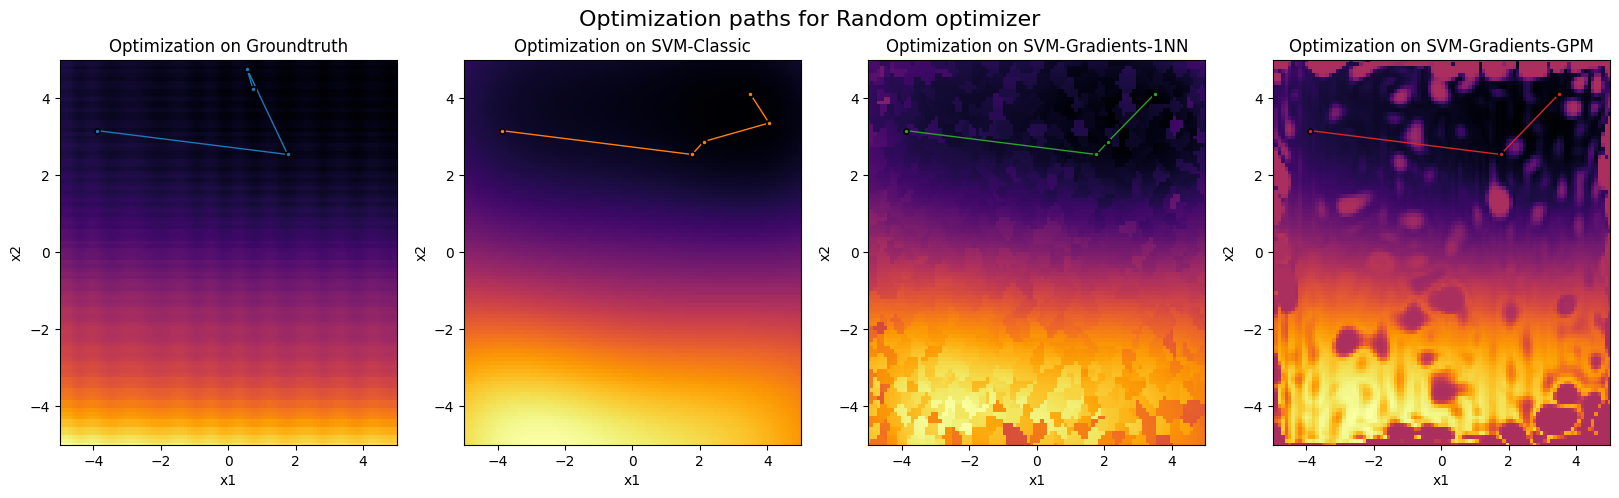

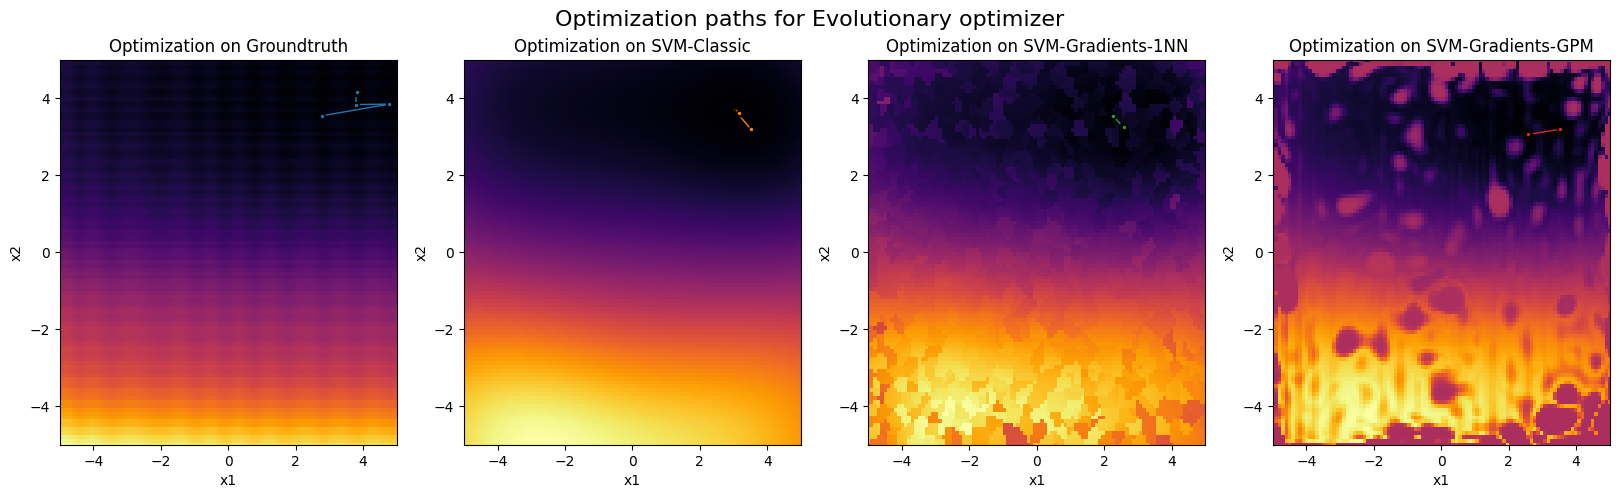

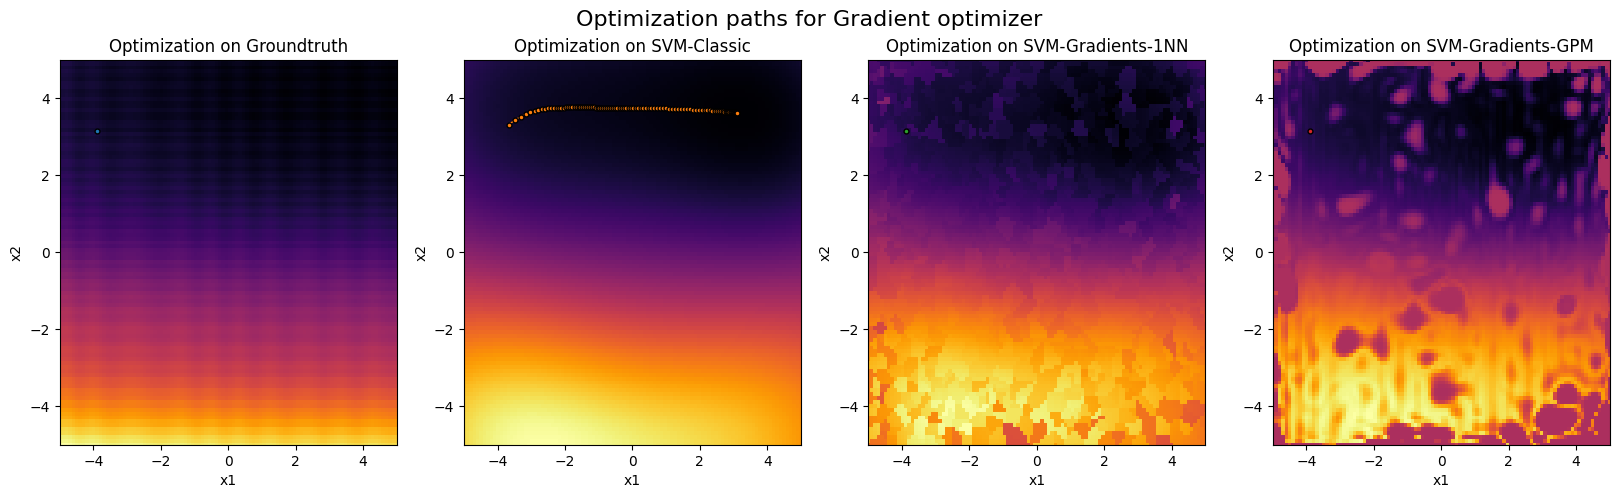

In [25]:
plot_optimization_paths(functions, 'Random', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'], seed=100).show()
plot_optimization_paths(functions, 'Evolutionary', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'], seed=100).show()
plot_optimization_paths(functions, 'Gradient', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'], seed=100).show()

### Evaluation with metrics

#### Correlation based

In [32]:
n_samples = 100
n_resampling = 10
df_corr_rho = pd.DataFrame(columns=[function[1] for function in functions])
df_corr_r = pd.DataFrame(columns=[function[1] for function in functions])

for i in range(n_resampling):
    X_test, y_test, _, _ = get_sample(problem_f03, n_samples=n_samples, n_dim=2, seed=i, method='random')
    row_r = []
    row_rho = []
    for function in functions:
        row_r.append(pearsonr(y_test, function[0](X_test))[0])
        row_rho.append(spearmanr(y_test, function[0](X_test))[0])
    df_corr_rho.loc[len(df_corr_rho)] = row_rho
    df_corr_r.loc[len(df_corr_r)] = row_r

c:\Users\User\OneDrive\Dokumente\Duales Studium\Theoriephasen\6. Theoriephase\Machine Learning Project (W3WI_DS305.2)\OptimizationTestfunctionGeneration\main\gt_sampling.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_sample = torch.tensor(result[i], dtype=torch.float64).reshape((1, n_dim)).float()
c:\Users\User\OneDrive\Dokumente\Duales Studium\Theoriephasen\6. Theoriephase\Machine Learning Project (W3WI_DS305.2)\OptimizationTestfunctionGeneration\main\gt_sampling.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_sample = torch.tensor(result[i], dtype=torch.float64).reshape((1, n_dim)).float()
c:\Users\User\OneDrive\Dokumente\Duales Studium\Theoriephasen\6. Theorie

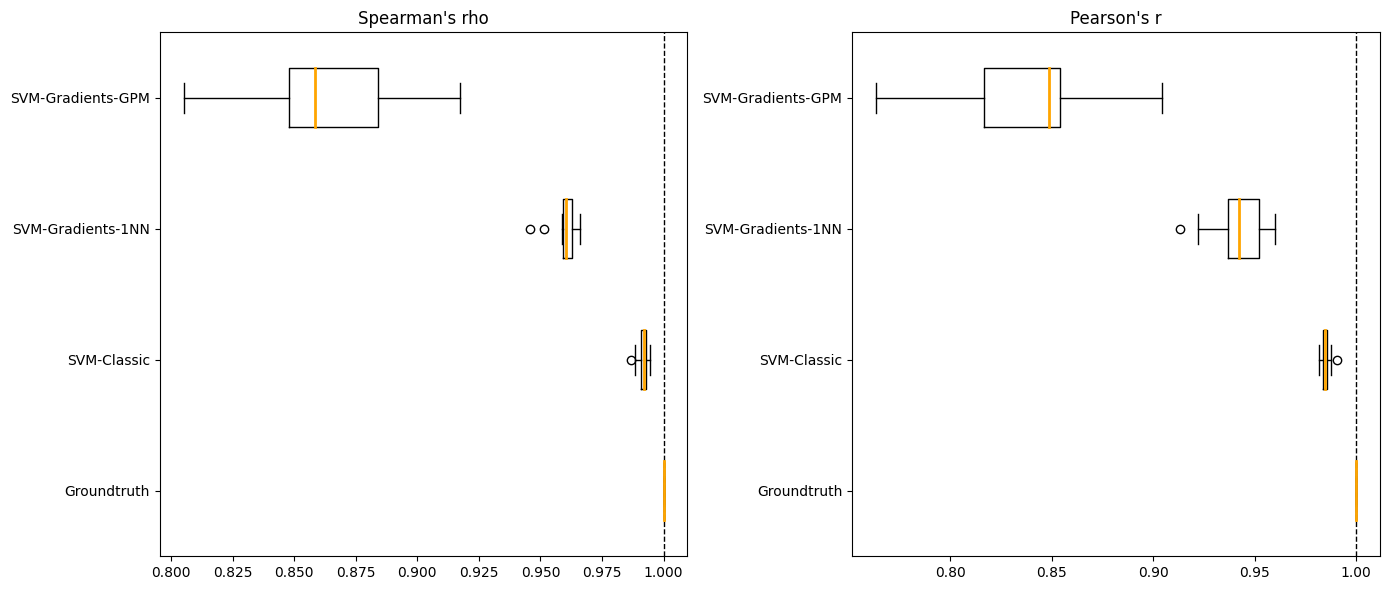

In [33]:
# boxplot of correlation coefficients
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.title("Spearman's rho")
df_corr_rho.boxplot(grid=False, vert=False, medianprops={'color': 'orange', 'linewidth': 2}, whiskerprops={'color': 'black', 'linewidth': 1}, capprops={'color': 'black', 'linewidth': 1}, flierprops={'color': 'black', 'linewidth': 1}, boxprops={'color': 'black', 'linewidth': 1})
plt.vlines(x=1, ymin=0.5, ymax=len(df_corr_rho.columns)+0.5, color='black', linestyles='dashed', linewidth=1)
plt.subplot(122)
plt.title("Pearson's r")
df_corr_r.boxplot(grid=False, vert=False, medianprops={'color': 'orange', 'linewidth': 2}, whiskerprops={'color': 'black', 'linewidth': 1}, capprops={'color': 'black', 'linewidth': 1}, flierprops={'color': 'black', 'linewidth': 1}, boxprops={'color': 'black', 'linewidth': 1})
plt.vlines(x=1, ymin=0.5, ymax=len(df_corr_rho.columns)+0.5, color='black', linestyles='dashed', linewidth=1)
plt.tight_layout()
plt.show()

#### Optimizer-based
- number of iterations compared to on groundtruth
- coordinates of the found optimum compared to on the groundtruth
- y-value of the found optimum compared to on the groundtruth
- Correlation r between the evaluations of the optimizers compared to on groundtruth
- MSE between the evaluations of the optimizers compared to on groundtruth

each considering the mean values over x trials, for each optimizer

In [34]:
optims = ['Random', 'Evolutionary', 'Gradient']
n_trials = 30

In [37]:
df_nr_iter, df_optim_loc, df_optim_val, df_r, df_mse = calculate_eval_metrics(functions, optims, n_trials)

c:\Users\User\.conda\envs\MachineLearningProject\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Number of iterations

In [38]:
df_nr_iter

,Groundtruth,SVM-Classic,SVM-Gradients-1NN,SVM-Gradients-GPM
Random,100.0±0.0,100.0±0.0,100.0±0.0,100.0±0.0
Evolutionary,36.27±3.8,25.5±2.35,65.8±7.74,96.0±9.38
Gradient,1.3±0.69,76.2±21.98,5.23±3.49,2.0±1.61


Optimum Location

In [39]:
df_optim_loc

,Groundtruth,SVM-Classic,SVM-Gradients-1NN,SVM-Gradients-GPM
Random,[3.01 4.13]±[1.37 0.53],[3.16 3.59]±[0.53 0.28],[2.53 3.58]±[0.96 0.57],[2.57 3.38]±[0.69 0.35]
Evolutionary,[3.79 4.16]±[0.18 0.1 ],[3.16 3.62]±[0. 0.],[2.58 3.3 ]±[0.06 0.11],[2.78 3.34]±[0.55 0.22]
Gradient,[0.18 1.97]±[2.12 2.55],[3.15 3.62]±[0.03 0. ],[-182.46 -180.85]±[659.38 661.25],[-82.1 -80.07]±[318.61 319.67]


Optimum Value

In [40]:
df_optim_val

,Groundtruth,SVM-Classic,SVM-Gradients-1NN,SVM-Gradients-GPM
Random,-488.18±6.07,-477.11±2.8,-475.22±8.46,-478.0±5.21
Evolutionary,-499.24±0.34,-479.9±0.0,-485.09±0.54,-485.06±0.39
Gradient,-352.63±171.34,-479.89±0.02,-422.92±72.71,-377.14±99.93


R^2 Score of Optimization Curves

In [41]:
df_r

,Groundtruth,SVM-Classic,SVM-Gradients-1NN,SVM-Gradients-GPM
Random,1.0±0.0,0.63±0.23,0.72±0.2,0.69±0.18
Evolutionary,1.0±0.0,0.78±0.15,0.81±0.14,0.83±0.15
Gradient,0.2±0.4,0.1±0.22,0.13±0.3,0.06±0.23


MSE Score of Optimization Curves

In [42]:
df_mse

,Groundtruth,SVM-Classic,SVM-Gradients-1NN,SVM-Gradients-GPM
Random,0.0±0.0,2028.3±2143.71,2616.56±3522.27,2496.82±2551.74
Evolutionary,0.0±0.0,359.69±13.84,199.69±21.34,198.14±14.47
Gradient,0.0±0.0,43519.15±97438.22,45164.13±92945.17,46876.09±99934.16
